In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention, CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf300 = pd.read_json('evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
# display(dnf_eval.head(2))
dnf_eval.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 500
# for idx in articles.keys():
#     num = len(articles[idx])
#     if num>=max_sentences:
#         max_sentences = num
        
max_sentences

500

In [5]:
titles = sorted(dnf300.headline.unique())
len(titles)

300

In [6]:
test_titles = sorted(dnf_eval.headline.unique())

In [7]:
titles = sorted(dnf300.headline.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))


In [8]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [9]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[ 51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]


(202, 51, 50)

In [10]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [11]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claim_ids'].values[0]
            ar_claims.append(cl)
            
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
            except Exception as ex:
                print(ex)
                print(idx)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [12]:
tdg = datagen_dnf(train_batchsize,dnf300,mode='train')
vdg = datagen_dnf(val_batchsize,dnf300,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf300,mode='test')

In [13]:
x,y = next(test_dg)

In [14]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

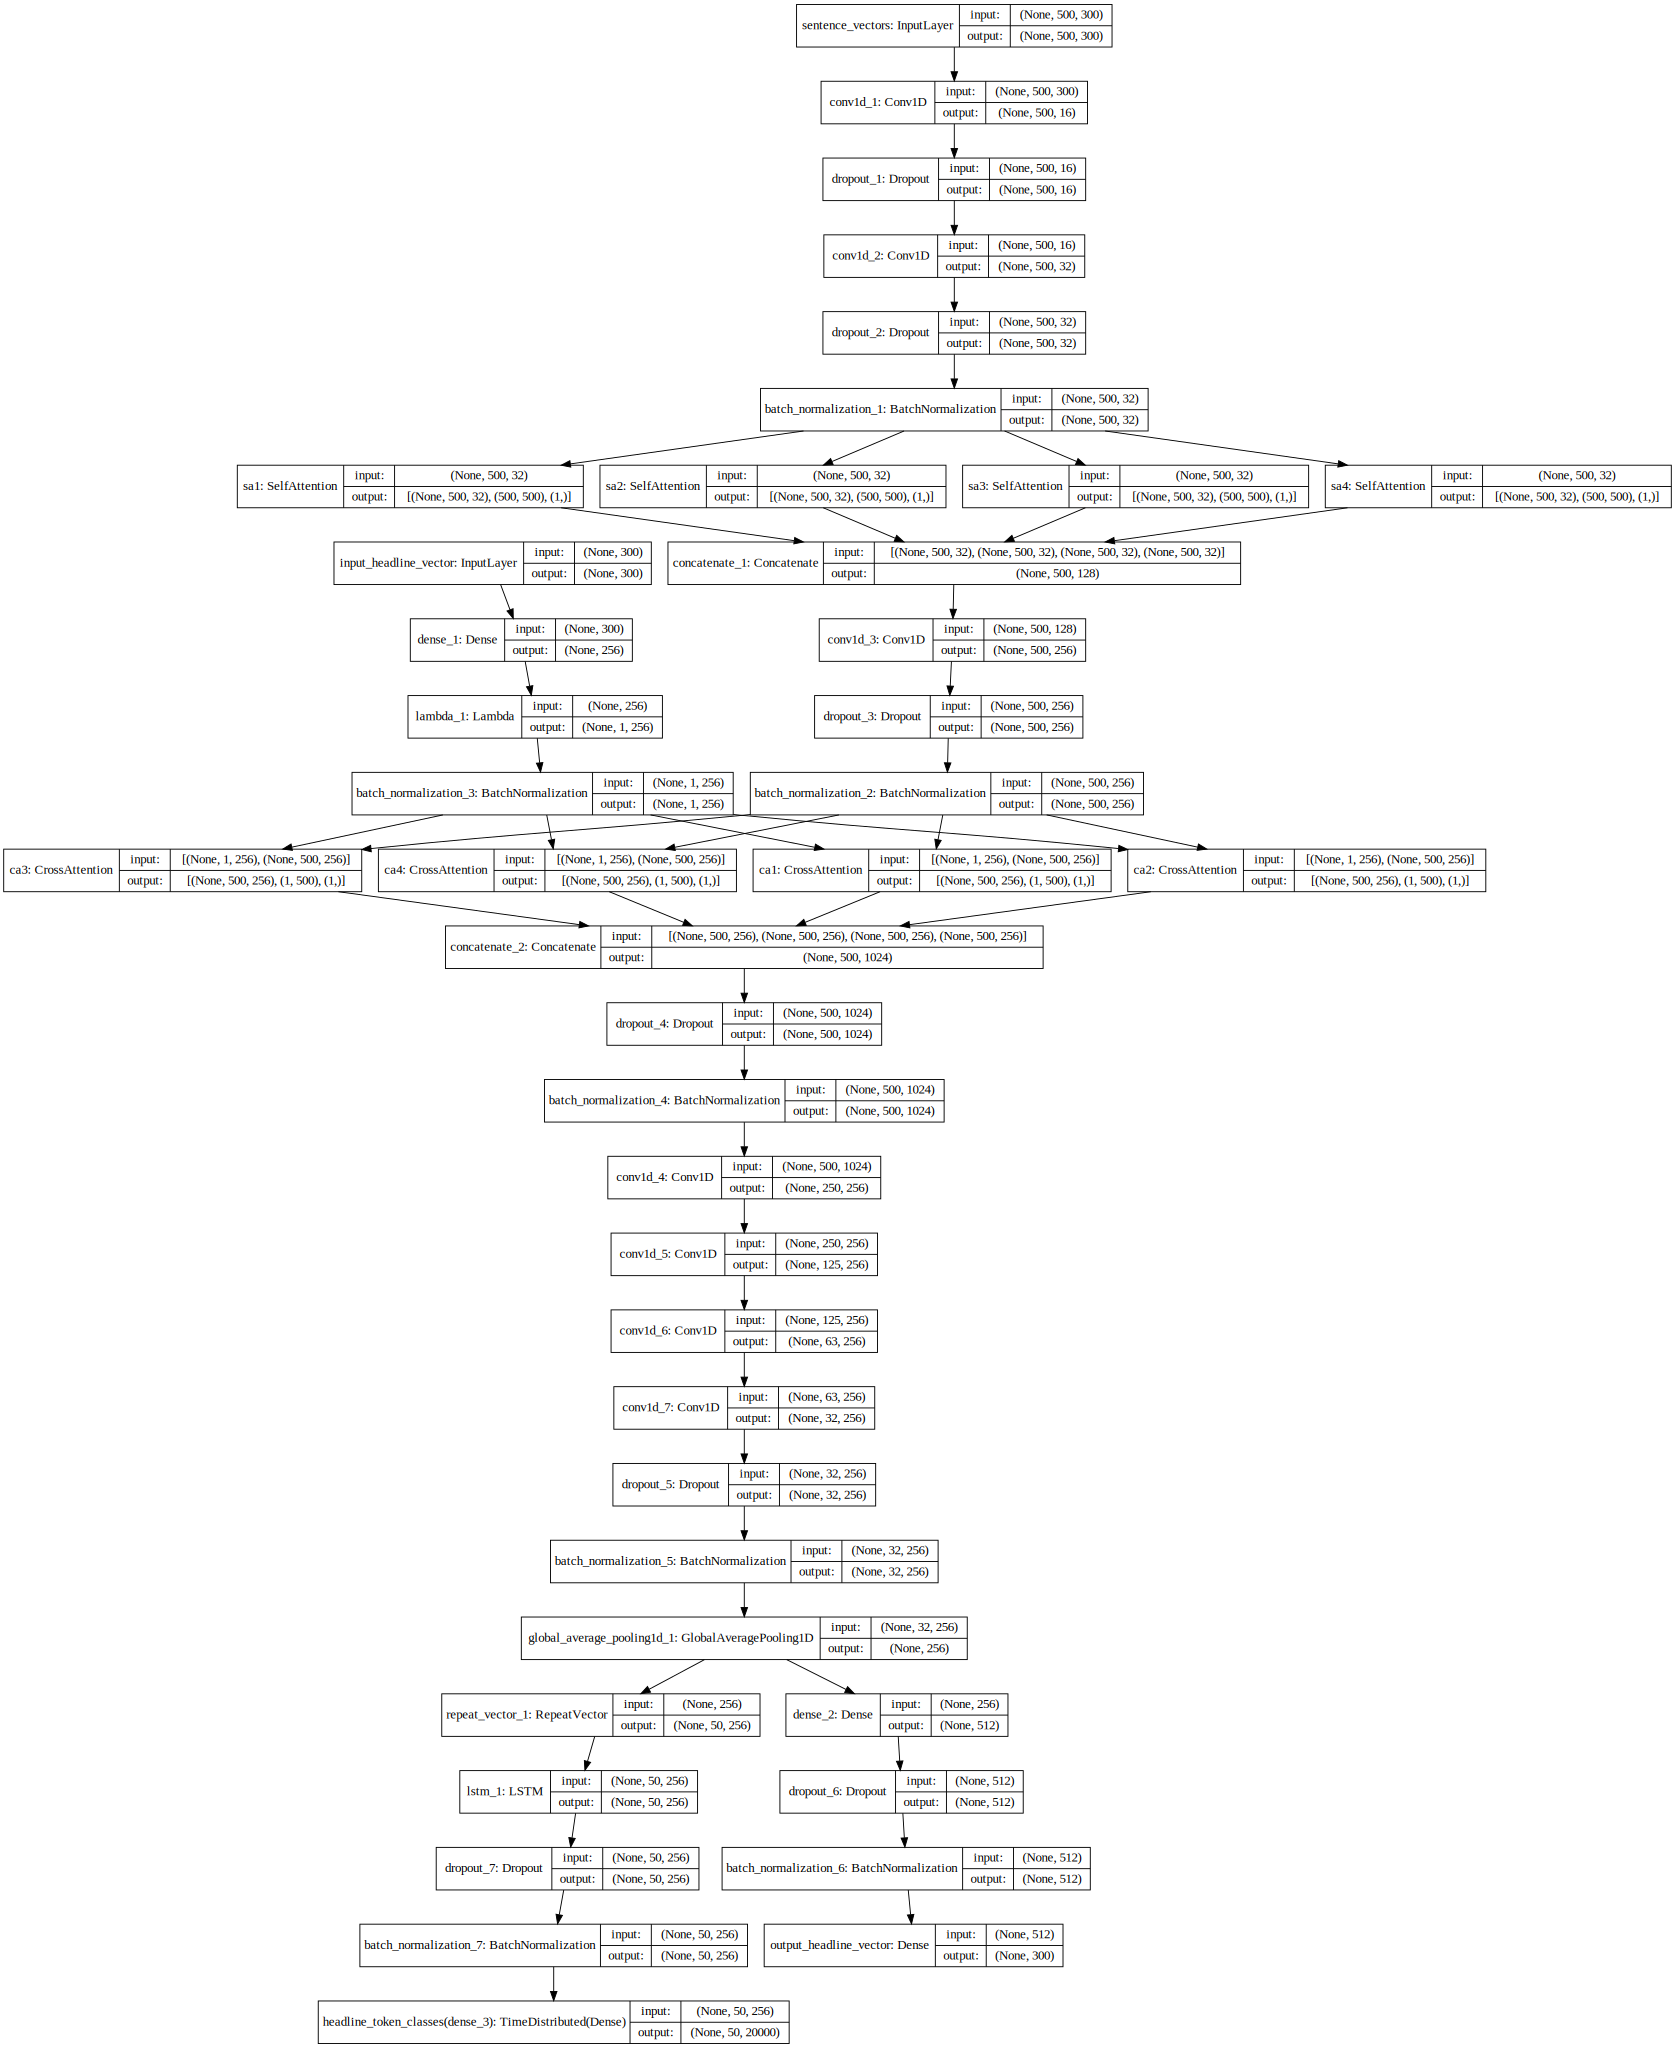

In [15]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_word = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],[gen_hd_vector,gen_hd_word])
    return model
model = build_model()
losses = {
    'output_headline_vector':'mse'
    ,'headline_token_classes':'categorical_crossentropy'
}
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss=losses)
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [16]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf300_sa_sent_hd_vector_word_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf300_sa_sent_hd_vector_word_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [17]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 47s 12s/step - loss: 11.0781 - output_headline_vector_loss: 1.1668 - headline_token_classes_loss: 9.9113 - val_loss: 10.3346 - val_output_headline_vector_loss: 0.5212 - val_headline_token_classes_loss: 9.8134
Epoch 2/2000
4/4 [==============================] - 2s 500ms/step - loss: 11.0577 - output_headline_vector_loss: 1.1555 - headline_token_classes_loss: 9.9023 - val_loss: 10.2278 - val_output_headline_vector_loss: 0.4715 - val_headline_token_classes_loss: 9.7563
Epoch 3/2000
4/4 [==============================] - 2s 516ms/step - loss: 11.0432 - output_headline_vector_loss: 1.1483 - headline_token_classes_loss: 9.8949 - val_loss: 10.1277 - val_output_headline_vector_loss: 0.4173 - val_headline_token_classes_loss: 9.7103
Epoch 4/2000
4/4 [==============================] - 2s 575ms/step - loss: 11.0333 - output_headline_vector_loss: 1.1427 - headline_token_classes_loss: 9.8906 - val_loss: 10.0846 - val_output_headline_vector_loss: 0.

Epoch 64/2000
4/4 [==============================] - 16s 4s/step - loss: 8.2881 - output_headline_vector_loss: 0.7223 - headline_token_classes_loss: 7.5658 - val_loss: 9.3542 - val_output_headline_vector_loss: 0.2036 - val_headline_token_classes_loss: 9.1506
Epoch 65/2000
4/4 [==============================] - 15s 4s/step - loss: 8.2570 - output_headline_vector_loss: 0.7272 - headline_token_classes_loss: 7.5298 - val_loss: 9.3197 - val_output_headline_vector_loss: 0.2019 - val_headline_token_classes_loss: 9.1178
Epoch 66/2000
4/4 [==============================] - 15s 4s/step - loss: 8.1876 - output_headline_vector_loss: 0.7133 - headline_token_classes_loss: 7.4743 - val_loss: 9.3581 - val_output_headline_vector_loss: 0.1833 - val_headline_token_classes_loss: 9.1748
Epoch 67/2000
4/4 [==============================] - 16s 4s/step - loss: 8.1810 - output_headline_vector_loss: 0.7189 - headline_token_classes_loss: 7.4621 - val_loss: 9.2433 - val_output_headline_vector_loss: 0.1778 - val_

Epoch 96/2000
4/4 [==============================] - 15s 4s/step - loss: 6.8968 - output_headline_vector_loss: 0.6042 - headline_token_classes_loss: 6.2925 - val_loss: 7.8967 - val_output_headline_vector_loss: 0.0891 - val_headline_token_classes_loss: 7.8077
Epoch 97/2000
4/4 [==============================] - 14s 3s/step - loss: 6.8888 - output_headline_vector_loss: 0.5926 - headline_token_classes_loss: 6.2962 - val_loss: 7.9121 - val_output_headline_vector_loss: 0.0897 - val_headline_token_classes_loss: 7.8224
Epoch 98/2000
4/4 [==============================] - 15s 4s/step - loss: 6.7605 - output_headline_vector_loss: 0.5857 - headline_token_classes_loss: 6.1749 - val_loss: 7.7220 - val_output_headline_vector_loss: 0.0877 - val_headline_token_classes_loss: 7.6343
Epoch 99/2000
4/4 [==============================] - 15s 4s/step - loss: 6.7042 - output_headline_vector_loss: 0.5969 - headline_token_classes_loss: 6.1072 - val_loss: 7.8295 - val_output_headline_vector_loss: 0.0864 - val_

4/4 [==============================] - 14s 3s/step - loss: 4.8777 - output_headline_vector_loss: 0.3886 - headline_token_classes_loss: 4.4891 - val_loss: 4.6437 - val_output_headline_vector_loss: 0.0338 - val_headline_token_classes_loss: 4.6100
Epoch 159/2000
4/4 [==============================] - 15s 4s/step - loss: 4.7401 - output_headline_vector_loss: 0.3757 - headline_token_classes_loss: 4.3644 - val_loss: 4.8773 - val_output_headline_vector_loss: 0.0341 - val_headline_token_classes_loss: 4.8432
Epoch 160/2000
4/4 [==============================] - 15s 4s/step - loss: 4.7124 - output_headline_vector_loss: 0.3739 - headline_token_classes_loss: 4.3385 - val_loss: 4.7734 - val_output_headline_vector_loss: 0.0323 - val_headline_token_classes_loss: 4.7411
Epoch 161/2000
4/4 [==============================] - 15s 4s/step - loss: 4.6526 - output_headline_vector_loss: 0.3717 - headline_token_classes_loss: 4.2809 - val_loss: 4.8632 - val_output_headline_vector_loss: 0.0317 - val_headline_to

4/4 [==============================] - 14s 4s/step - loss: 3.4088 - output_headline_vector_loss: 0.1983 - headline_token_classes_loss: 3.2105 - val_loss: 3.2393 - val_output_headline_vector_loss: 0.0215 - val_headline_token_classes_loss: 3.2177
Epoch 221/2000
4/4 [==============================] - 15s 4s/step - loss: 3.4267 - output_headline_vector_loss: 0.1954 - headline_token_classes_loss: 3.2314 - val_loss: 3.2168 - val_output_headline_vector_loss: 0.0187 - val_headline_token_classes_loss: 3.1981
Epoch 222/2000
4/4 [==============================] - 15s 4s/step - loss: 3.4584 - output_headline_vector_loss: 0.1975 - headline_token_classes_loss: 3.2609 - val_loss: 2.8625 - val_output_headline_vector_loss: 0.0192 - val_headline_token_classes_loss: 2.8433
Epoch 223/2000
4/4 [==============================] - 14s 3s/step - loss: 3.4431 - output_headline_vector_loss: 0.1987 - headline_token_classes_loss: 3.2445 - val_loss: 3.4999 - val_output_headline_vector_loss: 0.0196 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 2.4987 - output_headline_vector_loss: 0.0833 - headline_token_classes_loss: 2.4154 - val_loss: 2.6405 - val_output_headline_vector_loss: 0.0145 - val_headline_token_classes_loss: 2.6260
Epoch 283/2000
4/4 [==============================] - 15s 4s/step - loss: 2.5909 - output_headline_vector_loss: 0.0834 - headline_token_classes_loss: 2.5075 - val_loss: 3.0248 - val_output_headline_vector_loss: 0.0139 - val_headline_token_classes_loss: 3.0110
Epoch 284/2000
4/4 [==============================] - 14s 4s/step - loss: 2.5638 - output_headline_vector_loss: 0.0764 - headline_token_classes_loss: 2.4873 - val_loss: 2.7707 - val_output_headline_vector_loss: 0.0125 - val_headline_token_classes_loss: 2.7581
Epoch 285/2000
4/4 [==============================] - 15s 4s/step - loss: 2.5522 - output_headline_vector_loss: 0.0826 - headline_token_classes_loss: 2.4697 - val_loss: 2.6057 - val_output_headline_vector_loss: 0.0126 - val_headline_to

4/4 [==============================] - 14s 4s/step - loss: 2.2114 - output_headline_vector_loss: 0.0384 - headline_token_classes_loss: 2.1730 - val_loss: 2.6523 - val_output_headline_vector_loss: 0.0132 - val_headline_token_classes_loss: 2.6391
Epoch 345/2000
4/4 [==============================] - 16s 4s/step - loss: 2.1175 - output_headline_vector_loss: 0.0351 - headline_token_classes_loss: 2.0825 - val_loss: 2.4602 - val_output_headline_vector_loss: 0.0121 - val_headline_token_classes_loss: 2.4481
Epoch 346/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1350 - output_headline_vector_loss: 0.0345 - headline_token_classes_loss: 2.1005 - val_loss: 2.7020 - val_output_headline_vector_loss: 0.0162 - val_headline_token_classes_loss: 2.6858
Epoch 347/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0990 - output_headline_vector_loss: 0.0373 - headline_token_classes_loss: 2.0617 - val_loss: 2.4611 - val_output_headline_vector_loss: 0.0103 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 1.8160 - output_headline_vector_loss: 0.0229 - headline_token_classes_loss: 1.7931 - val_loss: 2.5165 - val_output_headline_vector_loss: 0.0123 - val_headline_token_classes_loss: 2.5042
Epoch 407/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9003 - output_headline_vector_loss: 0.0226 - headline_token_classes_loss: 1.8776 - val_loss: 2.2767 - val_output_headline_vector_loss: 0.0115 - val_headline_token_classes_loss: 2.2652
Epoch 408/2000
4/4 [==============================] - 14s 4s/step - loss: 1.8335 - output_headline_vector_loss: 0.0229 - headline_token_classes_loss: 1.8106 - val_loss: 2.5497 - val_output_headline_vector_loss: 0.0124 - val_headline_token_classes_loss: 2.5372
Epoch 409/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9393 - output_headline_vector_loss: 0.0217 - headline_token_classes_loss: 1.9176 - val_loss: 2.3644 - val_output_headline_vector_loss: 0.0128 - val_headline_to

4/4 [==============================] - 14s 4s/step - loss: 2.7336 - output_headline_vector_loss: 0.0167 - headline_token_classes_loss: 2.7170 - val_loss: 3.2860 - val_output_headline_vector_loss: 0.0122 - val_headline_token_classes_loss: 3.2738
Epoch 469/2000
4/4 [==============================] - 14s 4s/step - loss: 2.6562 - output_headline_vector_loss: 0.0174 - headline_token_classes_loss: 2.6388 - val_loss: 3.2783 - val_output_headline_vector_loss: 0.0103 - val_headline_token_classes_loss: 3.2680
Epoch 470/2000
4/4 [==============================] - 15s 4s/step - loss: 2.7105 - output_headline_vector_loss: 0.0162 - headline_token_classes_loss: 2.6943 - val_loss: 3.0878 - val_output_headline_vector_loss: 0.0129 - val_headline_token_classes_loss: 3.0749
Epoch 471/2000
4/4 [==============================] - 15s 4s/step - loss: 2.6030 - output_headline_vector_loss: 0.0171 - headline_token_classes_loss: 2.5859 - val_loss: 3.2940 - val_output_headline_vector_loss: 0.0092 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 2.3100 - output_headline_vector_loss: 0.0129 - headline_token_classes_loss: 2.2971 - val_loss: 2.5794 - val_output_headline_vector_loss: 0.0099 - val_headline_token_classes_loss: 2.5695
Epoch 531/2000
4/4 [==============================] - 15s 4s/step - loss: 2.4174 - output_headline_vector_loss: 0.0124 - headline_token_classes_loss: 2.4050 - val_loss: 2.5567 - val_output_headline_vector_loss: 0.0108 - val_headline_token_classes_loss: 2.5460
Epoch 532/2000
4/4 [==============================] - 15s 4s/step - loss: 2.3221 - output_headline_vector_loss: 0.0127 - headline_token_classes_loss: 2.3094 - val_loss: 2.8739 - val_output_headline_vector_loss: 0.0097 - val_headline_token_classes_loss: 2.8642
Epoch 533/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1366 - output_headline_vector_loss: 0.0136 - headline_token_classes_loss: 2.1230 - val_loss: 2.6134 - val_output_headline_vector_loss: 0.0108 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 2.3589 - output_headline_vector_loss: 0.0110 - headline_token_classes_loss: 2.3479 - val_loss: 2.8082 - val_output_headline_vector_loss: 0.0102 - val_headline_token_classes_loss: 2.7981
Epoch 593/2000
4/4 [==============================] - 14s 3s/step - loss: 2.3640 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 2.3528 - val_loss: 2.7945 - val_output_headline_vector_loss: 0.0114 - val_headline_token_classes_loss: 2.7831
Epoch 594/2000
4/4 [==============================] - 15s 4s/step - loss: 2.2533 - output_headline_vector_loss: 0.0118 - headline_token_classes_loss: 2.2415 - val_loss: 2.6998 - val_output_headline_vector_loss: 0.0130 - val_headline_token_classes_loss: 2.6867
Epoch 595/2000
4/4 [==============================] - 15s 4s/step - loss: 2.4101 - output_headline_vector_loss: 0.0114 - headline_token_classes_loss: 2.3987 - val_loss: 2.3003 - val_output_headline_vector_loss: 0.0125 - val_headline_to

4/4 [==============================] - 16s 4s/step - loss: 2.4227 - output_headline_vector_loss: 0.0113 - headline_token_classes_loss: 2.4114 - val_loss: 2.7917 - val_output_headline_vector_loss: 0.0106 - val_headline_token_classes_loss: 2.7812
Epoch 655/2000
4/4 [==============================] - 15s 4s/step - loss: 2.2470 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 2.2354 - val_loss: 2.7087 - val_output_headline_vector_loss: 0.0118 - val_headline_token_classes_loss: 2.6969
Epoch 656/2000
4/4 [==============================] - 15s 4s/step - loss: 2.3778 - output_headline_vector_loss: 0.0123 - headline_token_classes_loss: 2.3655 - val_loss: 2.5730 - val_output_headline_vector_loss: 0.0092 - val_headline_token_classes_loss: 2.5639
Epoch 657/2000
4/4 [==============================] - 15s 4s/step - loss: 2.2986 - output_headline_vector_loss: 0.0119 - headline_token_classes_loss: 2.2867 - val_loss: 2.6887 - val_output_headline_vector_loss: 0.0094 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 2.2743 - output_headline_vector_loss: 0.0111 - headline_token_classes_loss: 2.2632 - val_loss: 2.6740 - val_output_headline_vector_loss: 0.0108 - val_headline_token_classes_loss: 2.6633
Epoch 717/2000
4/4 [==============================] - 16s 4s/step - loss: 2.3285 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 2.3173 - val_loss: 2.5401 - val_output_headline_vector_loss: 0.0114 - val_headline_token_classes_loss: 2.5286
Epoch 718/2000
4/4 [==============================] - 16s 4s/step - loss: 2.3416 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 2.3307 - val_loss: 3.0336 - val_output_headline_vector_loss: 0.0105 - val_headline_token_classes_loss: 3.0231
Epoch 719/2000
4/4 [==============================] - 15s 4s/step - loss: 2.3025 - output_headline_vector_loss: 0.0110 - headline_token_classes_loss: 2.2915 - val_loss: 2.5746 - val_output_headline_vector_loss: 0.0121 - val_headline_to

4/4 [==============================] - 13s 3s/step - loss: 2.1912 - output_headline_vector_loss: 0.0113 - headline_token_classes_loss: 2.1799 - val_loss: 2.6536 - val_output_headline_vector_loss: 0.0090 - val_headline_token_classes_loss: 2.6446
Epoch 779/2000
4/4 [==============================] - 15s 4s/step - loss: 2.2435 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 2.2327 - val_loss: 2.3900 - val_output_headline_vector_loss: 0.0125 - val_headline_token_classes_loss: 2.3775
Epoch 780/2000
4/4 [==============================] - 14s 3s/step - loss: 2.2077 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 2.1972 - val_loss: 2.3816 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.3705
Epoch 781/2000
4/4 [==============================] - 15s 4s/step - loss: 2.2013 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 2.1910 - val_loss: 2.3850 - val_output_headline_vector_loss: 0.0097 - val_headline_to

4/4 [==============================] - 14s 3s/step - loss: 1.9444 - output_headline_vector_loss: 0.0113 - headline_token_classes_loss: 1.9331 - val_loss: 2.3650 - val_output_headline_vector_loss: 0.0099 - val_headline_token_classes_loss: 2.3551
Epoch 841/2000
4/4 [==============================] - 14s 4s/step - loss: 2.0058 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.9955 - val_loss: 2.5090 - val_output_headline_vector_loss: 0.0095 - val_headline_token_classes_loss: 2.4995
Epoch 842/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0740 - output_headline_vector_loss: 0.0110 - headline_token_classes_loss: 2.0630 - val_loss: 2.7322 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 2.7209
Epoch 843/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0270 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 2.0165 - val_loss: 2.7078 - val_output_headline_vector_loss: 0.0098 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 1.9066 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.8958 - val_loss: 2.7015 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.6909
Epoch 903/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9594 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.9485 - val_loss: 2.6439 - val_output_headline_vector_loss: 0.0109 - val_headline_token_classes_loss: 2.6330
Epoch 904/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8979 - output_headline_vector_loss: 0.0111 - headline_token_classes_loss: 1.8868 - val_loss: 2.5497 - val_output_headline_vector_loss: 0.0098 - val_headline_token_classes_loss: 2.5400
Epoch 905/2000
4/4 [==============================] - 14s 3s/step - loss: 1.8575 - output_headline_vector_loss: 0.0119 - headline_token_classes_loss: 1.8456 - val_loss: 2.4470 - val_output_headline_vector_loss: 0.0098 - val_headline_to

4/4 [==============================] - 14s 4s/step - loss: 1.7783 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.7674 - val_loss: 2.7133 - val_output_headline_vector_loss: 0.0122 - val_headline_token_classes_loss: 2.7011
Epoch 965/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9686 - output_headline_vector_loss: 0.0101 - headline_token_classes_loss: 1.9585 - val_loss: 2.6716 - val_output_headline_vector_loss: 0.0112 - val_headline_token_classes_loss: 2.6605
Epoch 966/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9939 - output_headline_vector_loss: 0.0111 - headline_token_classes_loss: 1.9828 - val_loss: 2.6892 - val_output_headline_vector_loss: 0.0118 - val_headline_token_classes_loss: 2.6774
Epoch 967/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9411 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.9306 - val_loss: 2.4441 - val_output_headline_vector_loss: 0.0111 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 1.8310 - output_headline_vector_loss: 0.0102 - headline_token_classes_loss: 1.8208 - val_loss: 2.2938 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 2.2825
Epoch 1027/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8103 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 1.7991 - val_loss: 2.7478 - val_output_headline_vector_loss: 0.0090 - val_headline_token_classes_loss: 2.7388
Epoch 1028/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8359 - output_headline_vector_loss: 0.0114 - headline_token_classes_loss: 1.8245 - val_loss: 3.0859 - val_output_headline_vector_loss: 0.0089 - val_headline_token_classes_loss: 3.0770
Epoch 1029/2000
4/4 [==============================] - 14s 3s/step - loss: 1.7429 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.7320 - val_loss: 2.4602 - val_output_headline_vector_loss: 0.0108 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.7036 - output_headline_vector_loss: 0.0115 - headline_token_classes_loss: 1.6921 - val_loss: 2.7461 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.7354
Epoch 1089/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7807 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.7699 - val_loss: 2.4439 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 2.4325
Epoch 1090/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7084 - output_headline_vector_loss: 0.0110 - headline_token_classes_loss: 1.6974 - val_loss: 2.5702 - val_output_headline_vector_loss: 0.0100 - val_headline_token_classes_loss: 2.5602
Epoch 1091/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7337 - output_headline_vector_loss: 0.0104 - headline_token_classes_loss: 1.7233 - val_loss: 2.8338 - val_output_headline_vector_loss: 0.0124 - val_headline

4/4 [==============================] - 14s 4s/step - loss: 1.8333 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.8227 - val_loss: 2.7430 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.7320
Epoch 1151/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8722 - output_headline_vector_loss: 0.0104 - headline_token_classes_loss: 1.8619 - val_loss: 2.7987 - val_output_headline_vector_loss: 0.0091 - val_headline_token_classes_loss: 2.7896
Epoch 1152/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7883 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.7776 - val_loss: 2.5684 - val_output_headline_vector_loss: 0.0115 - val_headline_token_classes_loss: 2.5569
Epoch 1153/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8418 - output_headline_vector_loss: 0.0113 - headline_token_classes_loss: 1.8305 - val_loss: 2.8276 - val_output_headline_vector_loss: 0.0102 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.7914 - output_headline_vector_loss: 0.0110 - headline_token_classes_loss: 1.7804 - val_loss: 2.6264 - val_output_headline_vector_loss: 0.0109 - val_headline_token_classes_loss: 2.6155
Epoch 1213/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8030 - output_headline_vector_loss: 0.0119 - headline_token_classes_loss: 1.7911 - val_loss: 2.6559 - val_output_headline_vector_loss: 0.0120 - val_headline_token_classes_loss: 2.6439
Epoch 1214/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9668 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.9565 - val_loss: 2.6821 - val_output_headline_vector_loss: 0.0127 - val_headline_token_classes_loss: 2.6695
Epoch 1215/2000
4/4 [==============================] - 13s 3s/step - loss: 1.7586 - output_headline_vector_loss: 0.0119 - headline_token_classes_loss: 1.7467 - val_loss: 2.9811 - val_output_headline_vector_loss: 0.0117 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.8687 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.8584 - val_loss: 2.9843 - val_output_headline_vector_loss: 0.0128 - val_headline_token_classes_loss: 2.9715
Epoch 1275/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8281 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.8175 - val_loss: 2.8051 - val_output_headline_vector_loss: 0.0120 - val_headline_token_classes_loss: 2.7931
Epoch 1276/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8507 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.8400 - val_loss: 2.6784 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.6673
Epoch 1277/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7968 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.7860 - val_loss: 2.6479 - val_output_headline_vector_loss: 0.0097 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.8278 - output_headline_vector_loss: 0.0100 - headline_token_classes_loss: 1.8178 - val_loss: 2.7162 - val_output_headline_vector_loss: 0.0101 - val_headline_token_classes_loss: 2.7060
Epoch 1337/2000
4/4 [==============================] - 13s 3s/step - loss: 1.7763 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.7654 - val_loss: 2.8918 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.8807
Epoch 1338/2000
4/4 [==============================] - 13s 3s/step - loss: 1.6819 - output_headline_vector_loss: 0.0114 - headline_token_classes_loss: 1.6706 - val_loss: 2.6873 - val_output_headline_vector_loss: 0.0123 - val_headline_token_classes_loss: 2.6750
Epoch 1339/2000
4/4 [==============================] - 14s 4s/step - loss: 1.8566 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.8457 - val_loss: 2.8428 - val_output_headline_vector_loss: 0.0098 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.7846 - output_headline_vector_loss: 0.0104 - headline_token_classes_loss: 1.7742 - val_loss: 2.7716 - val_output_headline_vector_loss: 0.0122 - val_headline_token_classes_loss: 2.7595
Epoch 1399/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6970 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.6862 - val_loss: 2.6344 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.6233
Epoch 1400/2000
4/4 [==============================] - 14s 4s/step - loss: 1.7078 - output_headline_vector_loss: 0.0101 - headline_token_classes_loss: 1.6977 - val_loss: 2.8222 - val_output_headline_vector_loss: 0.0103 - val_headline_token_classes_loss: 2.8119
Epoch 1401/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8081 - output_headline_vector_loss: 0.0101 - headline_token_classes_loss: 1.7980 - val_loss: 2.9840 - val_output_headline_vector_loss: 0.0105 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.8446 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.8340 - val_loss: 2.8662 - val_output_headline_vector_loss: 0.0127 - val_headline_token_classes_loss: 2.8535
Epoch 1461/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8354 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.8249 - val_loss: 2.7666 - val_output_headline_vector_loss: 0.0128 - val_headline_token_classes_loss: 2.7538
Epoch 1462/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8906 - output_headline_vector_loss: 0.0102 - headline_token_classes_loss: 1.8805 - val_loss: 2.5359 - val_output_headline_vector_loss: 0.0139 - val_headline_token_classes_loss: 2.5219
Epoch 1463/2000
4/4 [==============================] - 14s 4s/step - loss: 1.7856 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.7750 - val_loss: 2.6233 - val_output_headline_vector_loss: 0.0107 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.8936 - output_headline_vector_loss: 0.0101 - headline_token_classes_loss: 1.8835 - val_loss: 2.7783 - val_output_headline_vector_loss: 0.0368 - val_headline_token_classes_loss: 2.7415
Epoch 1523/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7158 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.7050 - val_loss: 2.8466 - val_output_headline_vector_loss: 0.0420 - val_headline_token_classes_loss: 2.8047
Epoch 1524/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9255 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.9150 - val_loss: 2.8762 - val_output_headline_vector_loss: 0.0306 - val_headline_token_classes_loss: 2.8456
Epoch 1525/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8152 - output_headline_vector_loss: 0.0096 - headline_token_classes_loss: 1.8056 - val_loss: 2.8210 - val_output_headline_vector_loss: 0.0462 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.7705 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7601 - val_loss: 3.1335 - val_output_headline_vector_loss: 0.5644 - val_headline_token_classes_loss: 2.5692
Epoch 1585/2000
4/4 [==============================] - 14s 4s/step - loss: 1.8888 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.8785 - val_loss: 3.1514 - val_output_headline_vector_loss: 0.5462 - val_headline_token_classes_loss: 2.6052
Epoch 1586/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8589 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 1.8477 - val_loss: 3.2145 - val_output_headline_vector_loss: 0.4245 - val_headline_token_classes_loss: 2.7900
Epoch 1587/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7812 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.7705 - val_loss: 3.3142 - val_output_headline_vector_loss: 0.6478 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.9087 - output_headline_vector_loss: 0.0101 - headline_token_classes_loss: 1.8986 - val_loss: 5.2706 - val_output_headline_vector_loss: 1.5279 - val_headline_token_classes_loss: 3.7426
Epoch 1647/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8741 - output_headline_vector_loss: 0.0102 - headline_token_classes_loss: 1.8639 - val_loss: 4.8477 - val_output_headline_vector_loss: 1.4751 - val_headline_token_classes_loss: 3.3726
Epoch 1648/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7453 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 1.7337 - val_loss: 4.3395 - val_output_headline_vector_loss: 1.1744 - val_headline_token_classes_loss: 3.1651
Epoch 1649/2000
4/4 [==============================] - 14s 4s/step - loss: 1.8288 - output_headline_vector_loss: 0.0104 - headline_token_classes_loss: 1.8183 - val_loss: 5.3487 - val_output_headline_vector_loss: 1.6944 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.7221 - output_headline_vector_loss: 0.0100 - headline_token_classes_loss: 1.7121 - val_loss: 2.4889 - val_output_headline_vector_loss: 0.0117 - val_headline_token_classes_loss: 2.4773
Epoch 1709/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7606 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.7499 - val_loss: 2.8488 - val_output_headline_vector_loss: 0.0106 - val_headline_token_classes_loss: 2.8383
Epoch 1710/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6431 - output_headline_vector_loss: 0.0115 - headline_token_classes_loss: 1.6316 - val_loss: 2.7969 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.7862
Epoch 1711/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7681 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7576 - val_loss: 2.8970 - val_output_headline_vector_loss: 0.0105 - val_headline

4/4 [==============================] - 14s 4s/step - loss: 1.8220 - output_headline_vector_loss: 0.0104 - headline_token_classes_loss: 1.8116 - val_loss: 2.6460 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.6349
Epoch 1771/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8621 - output_headline_vector_loss: 0.0102 - headline_token_classes_loss: 1.8519 - val_loss: 2.5899 - val_output_headline_vector_loss: 0.0125 - val_headline_token_classes_loss: 2.5774
Epoch 1772/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8657 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.8553 - val_loss: 2.8271 - val_output_headline_vector_loss: 0.0096 - val_headline_token_classes_loss: 2.8175
Epoch 1773/2000
4/4 [==============================] - 14s 4s/step - loss: 1.9441 - output_headline_vector_loss: 0.0098 - headline_token_classes_loss: 1.9343 - val_loss: 2.6038 - val_output_headline_vector_loss: 0.0108 - val_headline

4/4 [==============================] - 13s 3s/step - loss: 1.9671 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.9562 - val_loss: 2.7834 - val_output_headline_vector_loss: 0.0094 - val_headline_token_classes_loss: 2.7740
Epoch 1833/2000
4/4 [==============================] - 14s 3s/step - loss: 2.0651 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 2.0547 - val_loss: 3.0392 - val_output_headline_vector_loss: 0.0105 - val_headline_token_classes_loss: 3.0287
Epoch 1834/2000
4/4 [==============================] - 14s 4s/step - loss: 1.9365 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 1.9252 - val_loss: 2.7811 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.7700
Epoch 1835/2000
4/4 [==============================] - 12s 3s/step - loss: 1.9957 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.9851 - val_loss: 2.4717 - val_output_headline_vector_loss: 0.0133 - val_headline

4/4 [==============================] - 12s 3s/step - loss: 1.8667 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.8563 - val_loss: 2.5441 - val_output_headline_vector_loss: 0.0133 - val_headline_token_classes_loss: 2.5308
Epoch 1895/2000
4/4 [==============================] - 13s 3s/step - loss: 1.9576 - output_headline_vector_loss: 0.0100 - headline_token_classes_loss: 1.9476 - val_loss: 2.8048 - val_output_headline_vector_loss: 0.0103 - val_headline_token_classes_loss: 2.7945
Epoch 1896/2000
4/4 [==============================] - 11s 3s/step - loss: 1.7268 - output_headline_vector_loss: 0.0115 - headline_token_classes_loss: 1.7152 - val_loss: 2.6102 - val_output_headline_vector_loss: 0.0104 - val_headline_token_classes_loss: 2.5998
Epoch 1897/2000
4/4 [==============================] - 13s 3s/step - loss: 1.7502 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.7392 - val_loss: 2.7313 - val_output_headline_vector_loss: 0.0125 - val_headline

4/4 [==============================] - 11s 3s/step - loss: 1.9723 - output_headline_vector_loss: 0.0102 - headline_token_classes_loss: 1.9620 - val_loss: 2.5227 - val_output_headline_vector_loss: 0.0102 - val_headline_token_classes_loss: 2.5125
Epoch 1957/2000
4/4 [==============================] - 10s 2s/step - loss: 1.8127 - output_headline_vector_loss: 0.0113 - headline_token_classes_loss: 1.8014 - val_loss: 2.4976 - val_output_headline_vector_loss: 0.0122 - val_headline_token_classes_loss: 2.4854
Epoch 1958/2000
4/4 [==============================] - 10s 2s/step - loss: 1.8021 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7916 - val_loss: 2.5215 - val_output_headline_vector_loss: 0.0117 - val_headline_token_classes_loss: 2.5098
Epoch 1959/2000
4/4 [==============================] - 11s 3s/step - loss: 1.7975 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.7866 - val_loss: 2.8986 - val_output_headline_vector_loss: 0.0089 - val_headline

In [18]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [19]:
# df_res = pd.DataFrame(hist.history)

In [20]:
# df_res[['loss','val_loss']].plot()

In [21]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [22]:
model.load_weights('weights/dnf300_sa_sent_hd_vector_word_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., steps=5, use_multiprocessing=True)`
  


[2.3137764930725098, 0.011120007000863552, 2.3026564598083494]

In [23]:
x,y = next(test_dg)
pred = model.predict(x)

In [24]:
# test_idx = np.random.randint(50)
# test_idx

In [25]:
for i in range(len(x['headline'])):
    
    print(i,":",x['article_id'][i],':',x['headline'][i])

0 : 93 : former nato chief: we need us as ‘world’s policeman’
1 : 12 : jill stein endorsed donald trump
2 : 30 : nsa whistleblower says dnc email hack was not by russia, but by us intelligence | alternative
3 : 99 : hillary personally ordered ‘donald duck’ troll campaign
4 : 22 : pentagon officials furious after clinton announces us response time for nuclear launch during debate
5 : 97 : hillary sold weapons to isis, wikileaks confirms
6 : 22 : pentagon officials furious after clinton announces us response time for nuclear launch during debate
7 : 0 : wikileaks confirms hillary sold weapons to isis... then drops another bombshell! breaking news
8 : 11 : fbi agent suspected in hillary email leaks found dead in apparent murder-suicide
9 : 91 : us officials see no link between trump and russia
10 : 22 : pentagon officials furious after clinton announces us response time for nuclear launch during debate
11 : 27 : trump accuses obama, hillary clinton of founding daesh
12 : 12 : jill stein e

In [26]:
test_idx = 36
x['sentences'][test_idx]


['An email released in the recent Wikileaks dump laid out Democrat presidential nominee Hillary Clinton’s real plan for the future — and it didn’t include justice, equality or fairness.',
 'Instead, Clinton’s plan for the future revolved around maintaining political power while working to create an “unaware” and “compliant” citizenry.',
 'The email came from Bill Ivey, who was appointed Chairman of the National Endowment for the Arts during President Bill Clinton’s second term.',
 'It was sent to Hillary Clinton’s campaign chairman John Podesta on March 13, 2016.',
 'In the email, Ivey considered how Clinton could fight against Trump’s appeal and suggested that simply falling back on previous policies wouldn’t work. “',
 'And as I’ve mentioned, we’ve all been quite content to demean government, drop civics and in general conspire to produce an unaware and compliant citizenry,” he said.',
 'Ivey admitted how the left has made secret plans to make the public oblivious to their devious pl

# Model Test

In [27]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [28]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [29]:
# g1,g2,g3,g4

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([0, 2, 7, 5, 3])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

8


-279.0557

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

"clinton camp demands 'compliant citizenry' for master plan"

[0, 1, 4]

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

0 : An email released in the recent Wikileaks dump laid out Democrat presidential nominee Hillary Clinton’s real plan for the future — and it didn’t include justice, equality or fairness.
2 : The email came from Bill Ivey, who was appointed Chairman of the National Endowment for the Arts during President Bill Clinton’s second term.
7 : Unawareness among voters, he insinuated, was a positive for Clinton and the campaign she is running.
5 : And as I’ve mentioned, we’ve all been quite content to demean government, drop civics and in general conspire to produce an unaware and compliant citizenry,” he said.
3 : It was sent to Hillary Clinton’s campaign chairman John Podesta on March 13, 2016.


In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

8


-279.0557

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

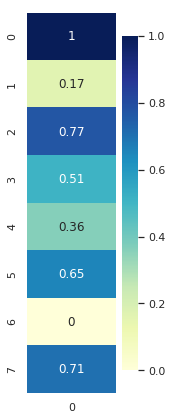

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 500, 32), (500, 5 2377      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sg1,sg2, sg3, sg4

(array([0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922,
        0.01742922, 0.01742922, 0.01742922, 0.01742922, 0.01742922],
       dtype=float32),
 array([-0.0084904, -0.0084904, -0.0084904, -0.0084904, -0.0084904,
        -0.0084904, -0.0084904, -0.0084904, -0.0084904, -0.0084904,
        -0.0084904, -0.0084904, -0.0084904, -0.0084904, -0.0084904,
        -0.0084904, -0.0084904, -0.0084904, -0.0084904, -0.0084904,
        -0.0084904, -0.0

In [41]:
sb = sb1[test_idx]+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(8, 8)

In [42]:
df_sb = pd.DataFrame(sb)


zx = df_sb.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
zx_scaled = min_max_scaler.fit_transform(zx)
df_sb = pd.DataFrame(zx_scaled)

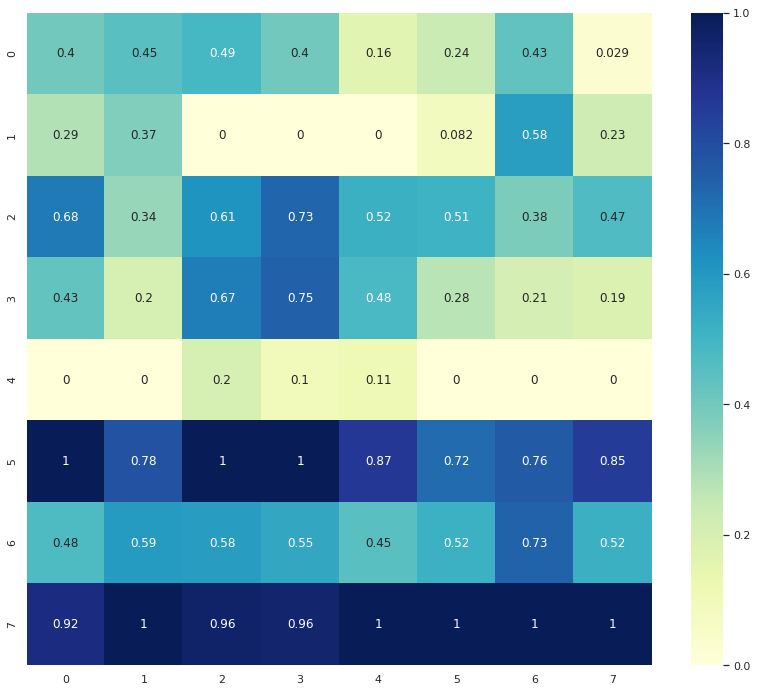

In [43]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [44]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"An email released in the recent Wikileaks dump laid out Democrat presidential nominee Hillary Clinton’s real plan for the future — and it didn’t include justice, equality or fairness."
1,"Instead, Clinton’s plan for the future revolved around maintaining political power while working to create an “unaware” and “compliant” citizenry."
2,"The email came from Bill Ivey, who was appointed Chairman of the National Endowment for the Arts during President Bill Clinton’s second term."
3,"It was sent to Hillary Clinton’s campaign chairman John Podesta on March 13, 2016."
4,"In the email, Ivey considered how Clinton could fight against Trump’s appeal and suggested that simply falling back on previous policies wouldn’t work. “"
5,"And as I’ve mentioned, we’ve all been quite content to demean government, drop civics and in general conspire to produce an unaware and compliant citizenry,” he said."
6,"Ivey admitted how the left has made secret plans to make the public oblivious to their devious plans, but he realized the public isn’t easy to manipulate, which is problematic for Democrats."
7,"Unawareness among voters, he insinuated, was a positive for Clinton and the campaign she is running."


In [45]:

def datagen_dnf_eval():

    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]

    for idx in dnf_eval.id: 
        hd = dnf_eval[dnf_eval.id==idx]['headline'].values[0].lower()
        ar_id = dnf_eval[dnf_eval.id==idx]['id'].values[0]
        cl = dnf_eval[dnf_eval.id==idx]['claim_ids'].values[0]
        ar_claims.append(cl)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]


        hds.append(hd)
        ar_sentences.append(sentences)
    #         print(len(sentences))
        sents = np.zeros((max_sentences,300))

        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))

        inputs = {
            'article_id': np.array(ar_ids)
            ,'headline': np.array(hds)
            ,'sentence_vectors' : np.array(ar_sents)
            ,'input_headline_vector': np.array(ar_head_vectors)
            ,'claims':np.array(ar_claims)
            ,'sentences':np.array(ar_sentences)
        }
        outputs = {
            'headline_token_classes': np.array(ar_head_classes)
            ,'output_headline_vector': np.array(ar_head_vectors)
        }
    return inputs,outputs
testX,testY = datagen_dnf_eval()

In [46]:

best_N = 5
_, b1, g1 = model_1.predict(testX)
_, b2, g2 = model_2.predict(testX)
_, b3, g3 = model_3.predict(testX)
_, b4, g4 = model_4.predict(testX)
ps, rs = [],[]
counter=0
for test_idx in range(len(testX['headline'])):    
    tp,fp,fn = 0,0,0
    claims = np.array(testX['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    pred = b[0][:len(testX['sentences'][test_idx])].argsort()[-best_N:][::-1]
    
#     print('claims:',claims)
#     print('pred:',pred)
    for p in pred:
        if p in claims:
            tp+=1
        else:
            fp+=1
    for c in claims:
        if c not in pred:
            fn+=1
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)
#     counter+=1
#     if counter==5:
#         break
#     print("----------------------------")
#     for s in t:
#         if s>=len(x['sentences'][test_idx]):continue
#         x['sentences'][test_idx][s]
np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.4210000000000001, 0.5713333333333332, 0.4847793080282164)

In [53]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
df_hd_tp_dnf.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls']
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)
ar_ids,ar_sents,ar_sentences,ar_head_vectors,ar_head_classes,hds,claims=[],[],[],[],[],[],[]
for idx in tqdm_notebook(test_titles):
#     print(idx)
    hd = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['Headline'].values[0].lower()
    hds.append(hd)
    ar_id = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['article Id'].values[0]
    cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
    claims.append(cl)
#     sentences=articles[ar_id]
#     ar_sentences.append(ar_sentences)
    #         print(len(sentences))
    sents = np.zeros((max_sentences,300))
    vectors = article_vectors[ar_id]
    sents[:len(vectors)] = vectors[:max_sentences]
    ar_ids.append(ar_id)
    ar_sents.append(sents)
    hd_nlp = nlp(hd.lower())
    head_classes = np.zeros(50, dtype='int')
    for i in range(len(hd_nlp)):
        head_classes[i] = hd_nlp[i].rank
    ar_head_vectors.append(hd_nlp.vector)
    ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
inputs = {
    'article_id': np.array(ar_ids)
    ,'headline': np.array(hds)
    ,'sentence_vectors' : np.array(ar_sents)
#     ,'sentences' : np.array(ar_sentences)
    ,'input_headline_vector': np.array(ar_head_vectors)
    ,'claims':np.array(claims)
}
outputs = {
    'headline_token_classes': np.array(ar_head_classes)
    ,'output_headline_vector': np.array(ar_head_vectors)
}
threshold = 0.95
best_N = 5
_, b1, g1 = model_1.predict(inputs)
_, b2, g2 = model_2.predict(inputs)
_, b3, g3 = model_3.predict(inputs)
_, b4, g4 = model_4.predict(inputs)
ps, rs = [],[]
counter=0
for test_idx in tqdm_notebook(range(len(inputs['headline']))):    
    tp,fp,fn = 0,0,0
    claims = np.array(inputs['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    ids = b[0][:len(articles[inputs['article_id'][test_idx]])].argsort()[-best_N:][::-1]
#     print(ids)
    pred = np.array(articles[inputs['article_id'][test_idx]])[ids]
#     print('claims:',claims)
#     print('pred:',pred)
    for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
        t5 = nlp(str(pred[i]))
        flag = False
        #pred_claim_sent.append(pred[i])
    #     print(t5.vector)
        for j in range(len(cl)):
            _c = nlp(cl[j])
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                tp+=1
                flag = True
                break
        if flag is False:
            fp+=1
        
            
   
    #     print(t5.vector)
    for j in range(len(cl)):
        _c = nlp(cl[j])
        flag = False
        for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
            t5 = nlp(str(pred[i]))
        
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                flag = True
                break
        if flag is False:
            fn+=1
         
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)

np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.24255319148936166, 0.1014977929871547, 0.14311026405356092)